![](logo_seurat.png){width=50% fig-align="center"}

# 들어가며

이전 [글](https://tomorrow-lab.github.io/posts/scRNAseq/python_scRNA_AnnData_mtx.html)에서는 `Scanpy`를 사용해 `10x genomics`의 `10X MEX` 포멧의 원시데이터를 불러오고 다시 `10X MEX format`형식으로 내보내는 내용을 살펴봤습니다. 이번에는 `Seurat`을 사용해 동일한 작업을 해봅니다.

# 예시 데이터

`10X genomics`의 `Cell Ranger` 결과물인 PBMC3k를 사용합니다. 자세한 것은 [링크](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)를 확인해주세요.

# 10X MEX to RDS

`Seurat`은 `Scanpy`와는 다르게 `R`언어로 만들어졌습니다. 그래서 기본적으로 범용적인 `RDS`형식으로 데이터를 저장합니다. `mtx`파일을 불러와서 `Seurat` 객체를 만들고 `RDS`파일로 저장해보겠습니다.

In [1]:
# 경고 메시지를 출력하지 않도록 설정합니다. 
# 기본값은 warn=0 입니다.
options(warn=-1)

# 패키지 로드 시 충돌 경고 메시지를 숨깁니다.
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Matrix))

In [2]:
# PBMC 데이터셋 로드
expression_matrix <- Read10X(data.dir = "../input/filtered_gene_bc_matrices/hg19/")

# Seurat 객체를 초기화합니다. 
seurat_obj <- CreateSeuratObject(
    counts = expression_matrix,  # 발현 행렬을 입력으로 사용합니다.
    project = "pbmc3k"           # 프로젝트 이름을 지정합니다.
)

# Seurat 객체를 반환합니다.
seurat_obj


An object of class Seurat 
32738 features across 2700 samples within 1 assay 
Active assay: RNA (32738 features, 0 variable features)
 1 layer present: counts

위 결과를 통해 pbmc3k의 원시 데이터에는 2,700개의 세포와 32,738개의 `feature`(유전자 정보)가 포함되어있다는 것을 알 수 있습니다.

# 기본적인 전처리

최소한의 전처리를 통해 불필요한 데이터는 제거하도록 하겠습니다.

In [3]:
# min.cells 및 min.features 매개변수를 사용하여 
# 최소 세포 및 최소 특징을 지정할 수 있습니다.
seurat_obj <- CreateSeuratObject(
    counts = expression_matrix,  
    project = "pbmc3k",          # 프로젝트 이름을 지정합니다.
    min.cells = 3,               # 각 특징이 포함된 최소 세포 수를 지정합니다.
    min.features = 200           # 각 세포에 대한 최소 특징 수를 지정합니다.
)

# Seurat 객체를 반환합니다.
seurat_obj

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

이제 `feature`가 많이 감소하였습니다. 추가로 미토콘드리아 유전자 비율과 세포당 `feature` 비율로 이상한 세포들을 제거합니다.

In [4]:
# Seurat 객체에 미토콘드리아 유전자 백분율 정보를 추가합니다.
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")

# Seurat 객체를 필터링하여 원시 데이터셋에서 특정 조건을 만족하는 세포들만 선택합니다.
# nFeature_RNA: RNA 발현 특징의 수
# percent.mt: MT 유전자 백분율
seurat_obj <- subset(
    seurat_obj,
    subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5
)

# 필터링된 Seurat 객체를 반환합니다.
seurat_obj

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

## UMAP 그리기

UMAP을 그리기 위해 아래 코드들을 실행합니다.

In [5]:
# 데이터 정규화
seurat_obj <- NormalizeData(object = seurat_obj, verbose = FALSE)

# 변수 특징 찾기
seurat_obj <- FindVariableFeatures(object = seurat_obj, verbose = FALSE)

# 데이터 스케일링
seurat_obj <- ScaleData(object = seurat_obj, verbose = FALSE)

# 주성분 분석 실행
seurat_obj <- RunPCA(
    object = seurat_obj,
    features = VariableFeatures(object = seurat_obj),
    verbose = FALSE
)

# 이웃 찾기
seurat_obj <- FindNeighbors(
    object = seurat_obj, dims = 1:10, verbose = FALSE
)

# 클러스터 찾기
seurat_obj <- FindClusters(
    object = seurat_obj, resolution = 0.5, verbose = FALSE
)

# UMAP 실행
seurat_obj <- RunUMAP(
    object = seurat_obj, dims = 1:10, verbose = FALSE
)

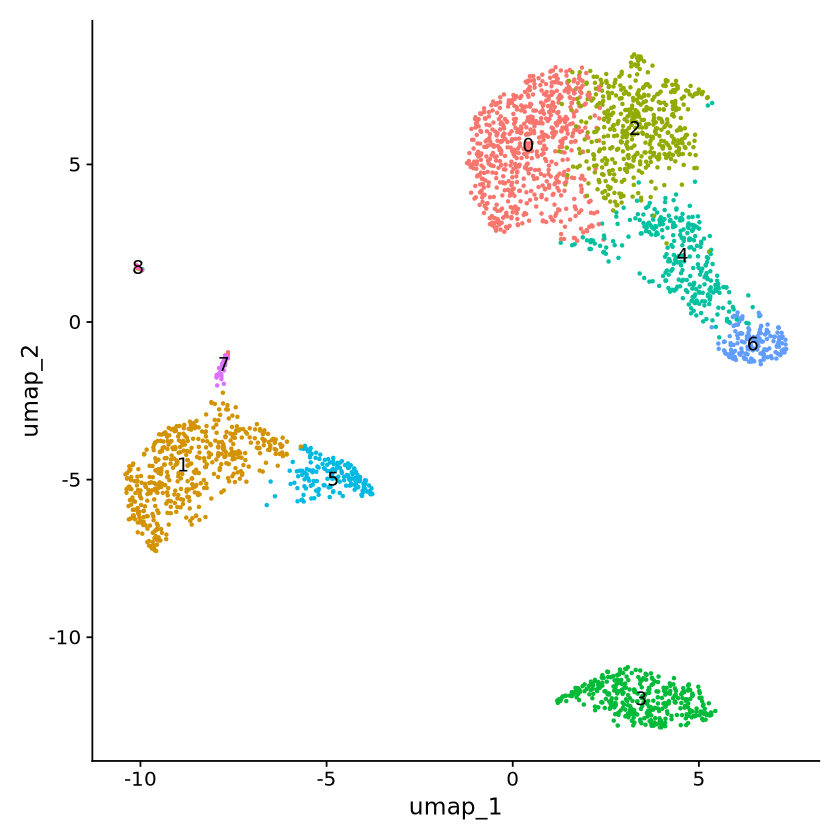

In [6]:
DimPlot(
    object = seurat_obj,
    label = TRUE,          # 각 데이터 포인트에 레이블 표시 여부
    reduction = "umap"    # UMAP 데이터 사용
) + NoLegend()            # 범례 숨기기

메타 데이터도 살펴봅니다.

In [7]:
head(seurat_obj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,2,2
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,3,3
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,2,2
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,1,1
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,6,6
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,2,2


`seurat_clusters`들이 숫자로 되어 있습니다. 이것을 `cell type annotation`작을 통해 아래와 같이 값을 바꿔줍니다.

In [8]:
# 클러스터 이름 재할당
seurat_obj[[]] <- seurat_obj[[]] %>%
  mutate(seurat_clusters = recode(
    seurat_clusters,
    `0` = "Naive CD4 T",
    `1` = "CD14+ Mono",
    `2` = "Memory CD4 T",
    `3` = "B",
    `4` = "CD8 T",
    `5` = "FCGR3A+ Mono",
    `6` = "NK",
    `7` = "DC",
    `8` = "Platelet"
  ))

# 수정된 클러스터 정보 확인
head(seurat_obj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,2,Memory CD4 T
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,3,B
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,2,Memory CD4 T
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,1,CD14+ Mono
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,6,NK
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,2,Memory CD4 T


다시 UMAP을 그려보겠습니다.

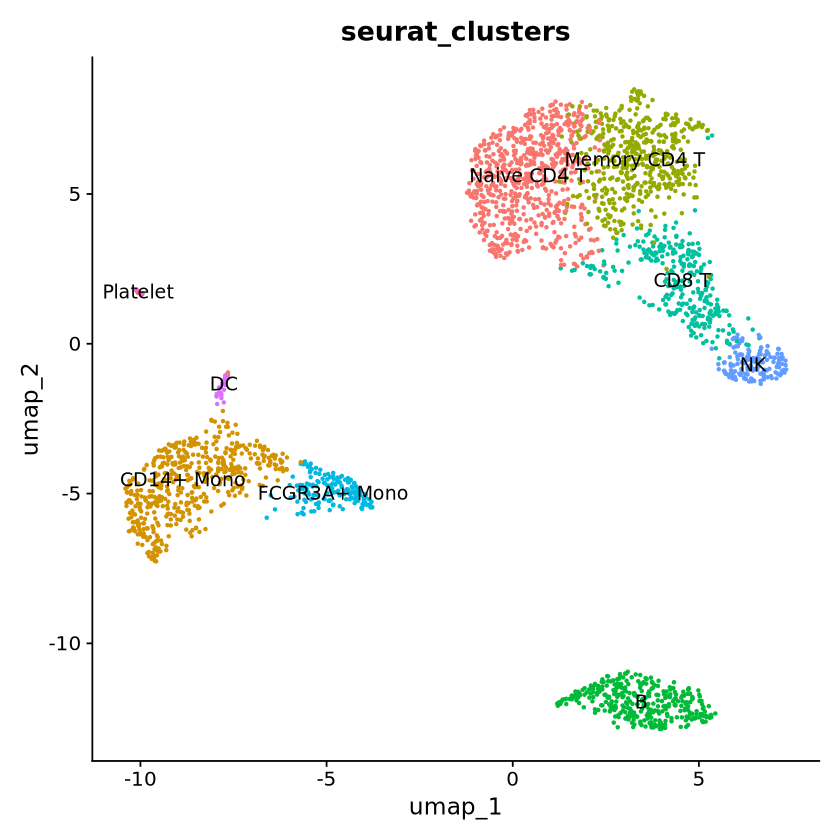

In [9]:
DimPlot(
  seurat_obj,
  reduction = "umap",
  label=TRUE,
  group.by="seurat_clusters") + NoLegend()

이제 `RDS`파일로 객체를 저장합니다.

In [10]:
output_path <- "../output/pbmc3k/"

# Seurat 객체를 RDS 파일로 저장
saveRDS(
    seurat_obj,
    file = paste0(output_path, "pbmc3k.rds")
)

# RDS to 10X MEX format

다시 `RDS`파일을 불러와서 `Seurat` 객체를 만들어 봅니다.

In [11]:
seurat_obj <- readRDS(
    paste0(output_path, "pbmc3k.rds")
)

seurat_obj

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

이제 아래와 같이 `mtx`, `tsv` 형식으로 데이터를 저장합니다.

:::{.callout-note}
`Seurat`은 유전자의 이름을 객체의 `rownames()`로 저장하기 때문에 `Scanpy`와는 달리 `ENSEMBL_ID` 정보가 소실되었습니다. 이 부분은 원시 데이터를 다시 불러와서 우회할 수 있습니다.
:::

In [12]:
# RNA 발현 행렬 데이터 추출
counts <- seurat_obj[["RNA"]]$counts

# 발현 행렬을 Matrix Market 형식의 파일로 저장
writeMM(counts, file = paste0(output_path,"matrix.mtx"))

# 세포 식별자(barcodes)를 추출
barcodes <- colnames(seurat_obj)

# 세포 식별자를 TSV 파일로 저장
write.table(barcodes, file = paste0(output_path,"barcodes.tsv"),
    row.names = FALSE, col.names = FALSE, quote = FALSE, sep = "\t")

# 유전자 정보를 추출
genes <- rownames(seurat_obj)

# 유전자 정보를 TSV 파일로 저장
write.table(genes, file = paste0(output_path, "genes.tsv"), 
    row.names = FALSE, col.names = FALSE, quote = FALSE, sep = "\t")

# 메타데이터 추출 (Seurat 객체의 meta.data에 저장됨)
meta_data <- seurat_obj[[]]

# 메타데이터를 TSV 파일로 저장
write.table(meta_data, file = paste0(output_path, "metadata.tsv"), 
    row.names = TRUE, col.names = TRUE, quote = FALSE, sep = "\t")

# UMAP 좌표 추출
umap <- Embeddings(seurat_obj, reduction = "umap")

# UMAP 좌표를 TSV 파일로 저장
write.table(umap, file = paste0(output_path, "UMAP.coords.tsv"), 
    row.names = TRUE, col.names = TRUE, quote = FALSE, sep = "\t")

# UMAP 좌표의 첫 번째 몇 개 행을 확인
head(umap)

NULL

,umap_1,umap_2
AAACATACAACCAC-1,2.864640,4.076900
AAACATTGAGCTAC-1,5.019568,-12.472298
AAACATTGATCAGC-1,4.590423,6.898579
AAACCGTGCTTCCG-1,-6.713953,-4.744311
AAACCGTGTATGCG-1,5.818774,-1.113903
AAACGCACTGGTAC-1,2.456097,6.181250


# 10X MEX to RDS 

위에서 저장한 파일들을 불러와 `Seurat` 객체를 만들어봅니다.

In [16]:
# Matrix Market 형식의 파일로부터 발현 행렬, 유전자 정보, 세포 식별자를 읽어옵니다.
expression_matrix <- ReadMtx(
  mtx = paste0(output_path, "matrix.mtx"),      # 발현 행렬 파일 경로
  features = paste0(output_path, "genes.tsv"),  # 유전자 정보 파일 경로
  cells = paste0(output_path, "barcodes.tsv"),  # 세포 식별자 파일 경로
  feature.column = 1                            # 유전자 정보 파일에서 사용할 열 인덱스
)

# Seurat 객체를 생성하고 발현 행렬을 입력 데이터로 사용합니다.
seurat_obj <- CreateSeuratObject(counts = expression_matrix)

# 메타데이터 파일을 읽어와 Seurat 객체의 메타데이터로 설정합니다.
seurat_obj[[]] <- read.table(
  paste0(output_path, "metadata.tsv"),           # 메타데이터 파일 경로
  stringsAsFactors = FALSE,                      # 문자열을 팩터로 변환하지 않음
  header = TRUE,                                 # 헤더가 있음
  sep = "\t",                                    # 탭으로 구분됨
  row.names = 1                                  # 행 이름 사용
)

# UMAP 좌표를 파일에서 읽어와 데이터 프레임으로 저장합니다.
UMAP_coordinates <- read.table(
  paste0(output_path, "UMAP.coords.tsv"),        # UMAP 좌표 파일 경로
  stringsAsFactors = FALSE,                      # 문자열을 팩터로 변환하지 않음
  header = TRUE,                                 # 헤더가 있음
  row.names = 1                                  # 행 이름 사용
)

# UMAP 좌표를 행렬로 변환합니다.
UMAP_coordinates_mat <- as(UMAP_coordinates, "matrix")

# DimReducObject를 생성하여 Seurat 객체에 UMAP 좌표를 추가합니다.
seurat_obj[['umap']] <- CreateDimReducObject(
  embeddings = UMAP_coordinates_mat,             # UMAP 좌표 행렬
  key = "UMAP_",                                 # UMAP 좌표 키
  global = TRUE,
  assay = "RNA"
)

# 수정된 Seurat 객체를 반환합니다.
seurat_obj

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts
 1 dimensional reduction calculated: umap

일부 데이터는 소실되었지만 `Seurat` 객체가 잘 만들어졌습니다. 메타데이터도 살펴보겠습니다.

In [17]:
head(seurat_obj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
,<chr>,<int>,<int>,<dbl>,<int>,<chr>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,2,Memory CD4 T
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,3,B
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,2,Memory CD4 T
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,1,CD14+ Mono
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,6,NK
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,2,Memory CD4 T


UMAP을 다시 그려 클러스터링 결과도 확인 해봅니다.

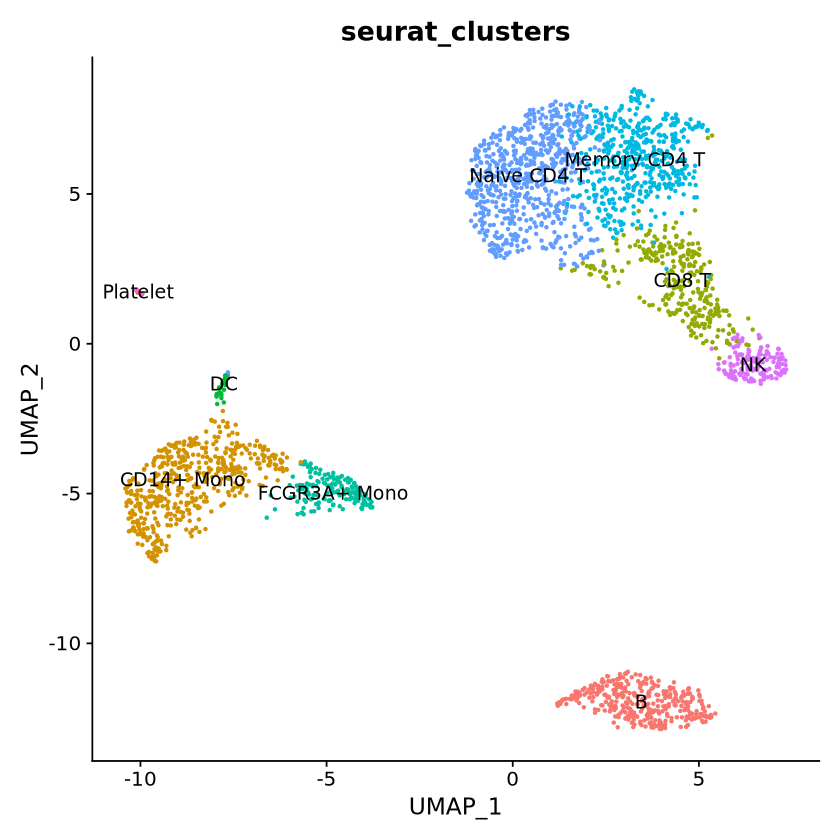

In [18]:
DimPlot(
  seurat_obj,
  reduction = "umap",
  label=TRUE,
  group.by="seurat_clusters") + NoLegend()

# 마치며

scRNA-seq 데이터 분석을 하다보면 분석 도구들이 `python` 혹은 `R`로 작성되어 있어, 사용자가 데이터를 이리 저리 변환해야 할 때가 많습니다. 그런 작업을 위해서는 여러 방법이 있지만 가장 간단한 `10X MEX` 형식으로 저장하는 것이 아무래도 가장 손이 덜가고 오류 가능성이 적다고 생각합니다.